In [ ]:
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

define loss tracker

In [ ]:
'''import visdom
vis = visdom.Visdom()
vis.close(env = "main")

def loss_tracker(loss_plot, loss_value, num):
  #num, loss_value, are Tensor
  vis.line(
      X=num,
      Y=loss_value,
      win = loss_plot,
      update = 'append'
  )'''

random seed & CPU/GPU

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

train, test Data load & transform  

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                 
])

trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle = True,num_workers =4)

testset = torchvision.datasets.CIFAR10(root='./data', train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle = False,num_workers =4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


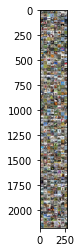

truck   car   car   cat


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
#functions to show an image

def imshow(img):
  img = img /2 + 0.5 #unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

#get some random training images
#matplot으로 하면 시간 걸려서 이사람은 visdom으로 함
detaiter = iter(trainloader)
images, labels = detaiter.next()
imshow(torchvision.utils.make_grid(images))

#visdom인 경우
'''detaiter = iter(trainloader)
images, labels = detaiter.next()
vis.images(images/2+0.5)'''

#print labels
print(' '.join('%5s' %classes[labels[j]] for j in range(4)))

Make VGG16 using import

In [ ]:
import torchvision.models.vgg as vgg

In [ ]:
#VGG16
cfg = [32,32, 'M', 64,64,128,128,128,'M',256,256,256,512,512,512,'M']

'''
32*32가 maxpooling(kernel_size = 2, stride = 2) 3번 거치면 4*4된다.
'''

'\n32*32가 maxpooling(kernel_size = 2, stride = 2) 3번 거치면 4*4된다.\n'

In [ ]:
class VGG(nn.Module):

    def __init__(
        self,
        features: nn.Module,
        num_classes: int = 1000,
        init_weights: bool = True
    ) -> None:
        super(VGG, self).__init__()
        self.features = features #convolution layer
        #self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        #FC
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096), 
            #linear layer의 input값(512*7*7)이 custom으로 한 경우, 'M'(maxpooling)의 갯수가 달라 이미지 크기다 다름
            #features랑 avgpool한 후, flatten한 후, 그에 맞게 변경해야!
            #32*32가 maxpooling(kernel_size = 2, stride = 2) 3번 거치면 4*4된다.
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x) #convolution
        #x = self.avgpool(x) #avgpool
        x = torch.flatten(x, 1) #flatten <=> x = x.view(x.size(0), -1)
        x = self.classifier(x) #FC layer
        return x

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [ ]:
vgg16 = VGG(vgg.make_layers(cfg), 10, True) #.to(device)

In [ ]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=

모델 문제 없는 지 test하기

In [ ]:
a = torch.Tensor(1,3,32,32) #.to(device)
out = vgg16(a)
print(out)

tensor([[-6.7168e+35,  1.2676e+35, -4.0403e+34, -5.7892e+34, -1.4927e+35,
         -1.1124e+36, -4.4101e+35,  1.1259e+36, -6.7161e+35, -1.6539e+35]],
       grad_fn=<AddmmBackward0>)


loss function & optimizer &learning_rate scheduler 설정


In [ ]:
#lossfunction
criterion = nn.CrossEntropyLoss()#.to(device)
#optimizer
optimizer = torch.optim.SGD(vgg16.parameters(), lr = 0.005, momentum = 0.9)
#lr scheduler
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.9)
'''
lr scheduler: epoch돌리는 동안 lr을 고정시키는 게 아니라, 정밀한 학습을 위해 
중간에 gamma값을 곱해줘서 감소(gamma < 1)시키거나 증가(gamma > 1)시키는 방법
step_size: lrscheduler step 5마다 lr에 gamma값을 곱해줌
'''

'\nlr scheduler: epoch돌리는 동안 lr을 고정시키는 게 아니라, 정밀한 학습을 위해 \n중간에 gamma값을 곱해줘서 감소(gamma < 1)시키거나 증가(gamma > 1)시키는 방법\nstep_size: lrscheduler step 5마다 lr에 gamma값을 곱해줌\n'

make plot

In [ ]:
#loss_plt = vis.line(Y=torch.Tensor(1).zero(), opts = dict(title='loss_tracker', legend =['loss'], showlegend=True))

Training

In [ ]:
print(len(trainloader))
epochs = 50

for epoch in range(epochs): #loop over the dataset mutiple times
  running_loss = 0.0
  lr_sche.step()
  for i, data in enumerate(trainloader, 0):
    #get inputs
    inputs, labels = data
    inputs = inputs #.to(device)
    labels = labels #.to(device)

    #zero the parameter gradients
    optimizer.zero_grad()
    #forward + backward + optimize
    outputs = vgg16(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    #print statistics
    running_loss += loss.item()
    if i % 30 == 29: #30번마다 print, loss_tracker
      #loss_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i+epoch*len(trainloader)]))
      print('[%d, %5d] loss: %.3f' %(epoch+1, i+1, running_loss/30))
      running_loss = 0.0

print('Finished Training')



98


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

[1,    30] loss: 2.302
[1,    60] loss: 2.298
[1,    90] loss: 2.288
[2,    30] loss: 2.158
[2,    60] loss: 2.002
[2,    90] loss: 1.942
[3,    30] loss: 1.827


KeyboardInterrupt: ignored

TEST trained model

In [ ]:
detaiter = iter(testloader)
images, labels = detaiter.next()

#print images
imshow(torchvision.utils.make_griad(images))
print('GroundTruth: ',' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
outputs = vgg16(images) #outputs = vgg16(images.to(device))

In [ ]:
_, predicted = torch.max(outputs, axis = 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]for j in range(4)))

In [ ]:
correct = 0
total = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images = images #.to(device)
    labels = labels #.to(device)
    outputs = vgg16(images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print('Accurace of the network on the 10000 test images : %d %%' %(100*correct / total))
